In [6]:
import json, torch, torch.nn as nn, numpy as np, pandas as pd
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from transformers import AutoTokenizer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load Your Datasets
with open("train-claims.json") as f:
    train_claims = json.load(f)
with open("dev-claims.json") as f:
    dev_claims = json.load(f)
with open("evidence.json") as f:
    evidence_data = json.load(f)

def claims_to_df(claims_dict):
    data = []
    for cid, v in claims_dict.items():
        ev_texts = [evidence_data[eid] for eid in v["evidences"] if eid in evidence_data]
        data.append({
            "claim_id": cid,
            "claim_text": v["claim_text"],
            "evidence_text": " ".join(ev_texts),
            "label": v["claim_label"]
        })
    return pd.DataFrame(data)

train_df = claims_to_df(train_claims)
dev_df = claims_to_df(dev_claims)
df = pd.concat([train_df, dev_df]).dropna()

label_encoder = LabelEncoder()
df["label_id"] = label_encoder.fit_transform(df["label"])

# Load Pretrained GloVe (100D)
!wget -q http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

def load_glove(path, tokenizer, dim=100):
    embeddings = {}
    with open(path, encoding="utf-8") as f:
        for line in f:
            values = line.strip().split()
            word, vec = values[0], np.asarray(values[1:], dtype="float32")
            embeddings[word] = vec
    vocab_size = tokenizer.vocab_size
    embed_matrix = np.zeros((vocab_size, dim))
    for word, idx in tokenizer.get_vocab().items():
        if word in embeddings:
            embed_matrix[idx] = embeddings[word]
    return torch.tensor(embed_matrix, dtype=torch.float)

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
glove_tensor = load_glove("glove.6B.100d.txt", tokenizer, dim=100)

# Dataset Class
class ClaimDataset(Dataset):
    def __init__(self, claims, evidences, labels, tokenizer, max_len=128):
        self.claims = claims
        self.evidences = evidences
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.claims)

    def __getitem__(self, idx):
        text = self.claims[idx] + " " + self.evidences[idx]
        enc = self.tokenizer(text, truncation=True, padding='max_length',
                             max_length=self.max_len, return_tensors='pt')
        return {
            "input_ids": enc["input_ids"].squeeze(0),
            "attention_mask": enc["attention_mask"].squeeze(0),
            "label": torch.tensor(self.labels[idx], dtype=torch.long)
        }

dev_df["label_id"] = label_encoder.transform(dev_df["label"])
train_df["label_id"] = label_encoder.transform(train_df["label"])
train_dataset = ClaimDataset(train_df["claim_text"].tolist(), train_df["evidence_text"].tolist(), train_df["label_id"].tolist(), tokenizer)
dev_dataset = ClaimDataset(dev_df["claim_text"].tolist(), dev_df["evidence_text"].tolist(), dev_df["label_id"].tolist(), tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=16)

# Compute Class Weights
weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(df["label_id"]),
    y=df["label_id"]
)
class_weights = torch.tensor(weights, dtype=torch.float).to(device)

# GRU Classifier with All Fixes
class GRUClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes, pad_idx, glove_matrix):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(glove_matrix, freeze=False, padding_idx=pad_idx)
        self.gru = nn.GRU(embed_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.layernorm = nn.LayerNorm(hidden_dim * 2)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(hidden_dim * 2, num_classes)

    def forward(self, input_ids, attention_mask=None):
        x = self.embedding(input_ids)
        x, _ = self.gru(x)
        x = torch.mean(x, dim=1)
        x = self.dropout(self.layernorm(x))
        return self.fc(x)

model = GRUClassifier(
    vocab_size=tokenizer.vocab_size,
    embed_dim=100,
    hidden_dim=64,
    num_classes=len(label_encoder.classes_),
    pad_idx=tokenizer.pad_token_id,
    glove_matrix=glove_tensor
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)
loss_fn = nn.CrossEntropyLoss(weight=class_weights)

# Training
def train_epoch(model, loader):
    model.train()
    total_loss = 0
    for batch in loader:
        input_ids = batch["input_ids"].to(device)
        labels = batch["label"].to(device)
        outputs = model(input_ids)
        loss = loss_fn(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

# Evaluation
from sklearn.metrics import classification_report
def evaluate(model, loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in loader:
            input_ids = batch["input_ids"].to(device)
            labels = batch["label"].to(device)
            outputs = model(input_ids)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    print(classification_report(all_labels, all_preds, target_names=label_encoder.classes_))

# Run Training + Evaluation
for epoch in range(20):
    loss = train_epoch(model, train_loader)
    print(f"Epoch {epoch+1} Loss: {loss:.4f}")

print("Evaluation on dev-claims.json:")
evaluate(model, dev_loader)


replace glove.6B.50d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: o
error:  invalid response [o]
replace glove.6B.50d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace glove.6B.100d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
n
n
A
n
Epoch 1 Loss: 1.4435
Epoch 2 Loss: 1.3562
Epoch 3 Loss: 1.3108
Epoch 4 Loss: 1.2821
Epoch 5 Loss: 1.2593
Epoch 6 Loss: 1.2025
Epoch 7 Loss: 1.1717
Epoch 8 Loss: 1.1341
Epoch 9 Loss: 1.1048
Epoch 10 Loss: 1.0471
Epoch 11 Loss: 1.0187
Epoch 12 Loss: 0.9684
Epoch 13 Loss: 0.9085
Epoch 14 Loss: 0.8710
Epoch 15 Loss: 0.8067
Epoch 16 Loss: 0.7370
Epoch 17 Loss: 0.6810
Epoch 18 Loss: 0.6005
Epoch 19 Loss: 0.5569
Epoch 20 Loss: 0.4827
Evaluation on dev-claims.json:
                 precision    recall  f1-score   support

       DISPUTED       0.09      0.06      0.07        18
NOT_ENOUGH_INFO       0.60      0.61      0.60        41
        REFUTES       0.31      0.41      0.35        27
       SUPPORTS       0.54      0.51      0.53        68

       accuracy

In [10]:
class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.attn = nn.Linear(hidden_dim * 2, 1)

    def forward(self, gru_output, mask=None):
        weights = self.attn(gru_output).squeeze(-1)
        if mask is not None:
            weights = weights.masked_fill(mask == 0, -1e9)
        attn_weights = torch.softmax(weights, dim=1).unsqueeze(-1)
        context = torch.sum(gru_output * attn_weights, dim=1)
        return context

class GRUClassifierWithAttention(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes, pad_idx, glove_matrix):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(glove_matrix, freeze=False, padding_idx=pad_idx)
        self.gru = nn.GRU(embed_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.attn = Attention(hidden_dim)
        self.layernorm = nn.LayerNorm(hidden_dim * 2)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(hidden_dim * 2, num_classes)

    def forward(self, input_ids, attention_mask=None):
        x = self.embedding(input_ids)
        output, _ = self.gru(x)
        context = self.attn(output, attention_mask)  # attention pooling
        context = self.dropout(self.layernorm(context))
        return self.fc(context)


In [11]:
def claims_to_df(claims_dict):
    data = []
    for cid, v in claims_dict.items():
        ev_texts = [evidence_data[eid] for eid in v["evidences"] if eid in evidence_data]
        data.append({
            "claim_id": cid,
            "claim_text": v["claim_text"],
            "evidence_text": " ".join(ev_texts),
            "label": v["claim_label"]
        })
    return pd.DataFrame(data)

train_df = claims_to_df(train_claims)
dev_df = claims_to_df(dev_claims)
df = pd.concat([train_df, dev_df]).dropna()

label_encoder = LabelEncoder()
df["label_id"] = label_encoder.fit_transform(df["label"])

def load_glove(path, tokenizer, dim=100):
    embeddings = {}
    with open(path, encoding="utf-8") as f:
        for line in f:
            values = line.strip().split()
            word, vec = values[0], np.asarray(values[1:], dtype="float32")
            embeddings[word] = vec
    vocab_size = tokenizer.vocab_size
    embed_matrix = np.zeros((vocab_size, dim))
    for word, idx in tokenizer.get_vocab().items():
        if word in embeddings:
            embed_matrix[idx] = embeddings[word]
    return torch.tensor(embed_matrix, dtype=torch.float)

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
glove_tensor = load_glove("glove.6B.100d.txt", tokenizer, dim=100)

# Dataset Class
class ClaimDataset(Dataset):
    def __init__(self, claims, evidences, labels, tokenizer, max_len=128):
        self.claims = claims
        self.evidences = evidences
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.claims)

    def __getitem__(self, idx):
        text = self.claims[idx] + " " + self.evidences[idx]
        enc = self.tokenizer(text, truncation=True, padding='max_length',
                             max_length=self.max_len, return_tensors='pt')
        return {
            "input_ids": enc["input_ids"].squeeze(0),
            "attention_mask": enc["attention_mask"].squeeze(0),
            "label": torch.tensor(self.labels[idx], dtype=torch.long)
        }

dev_df["label_id"] = label_encoder.transform(dev_df["label"])
train_df["label_id"] = label_encoder.transform(train_df["label"])
train_dataset = ClaimDataset(train_df["claim_text"].tolist(), train_df["evidence_text"].tolist(), train_df["label_id"].tolist(), tokenizer)
dev_dataset = ClaimDataset(dev_df["claim_text"].tolist(), dev_df["evidence_text"].tolist(), dev_df["label_id"].tolist(), tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=16)

# Compute Class Weights
weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(df["label_id"]),
    y=df["label_id"]
)
class_weights = torch.tensor(weights, dtype=torch.float).to(device)

class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.attn = nn.Linear(hidden_dim * 2, 1)

    def forward(self, gru_output, mask=None):
        weights = self.attn(gru_output).squeeze(-1)
        if mask is not None:
            weights = weights.masked_fill(mask == 0, -1e9)
        attn_weights = torch.softmax(weights, dim=1).unsqueeze(-1)
        context = torch.sum(gru_output * attn_weights, dim=1)
        return context

class GRUClassifierWithAttention(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes, pad_idx, glove_matrix):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(glove_matrix, freeze=False, padding_idx=pad_idx)
        self.gru = nn.GRU(embed_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.attn = Attention(hidden_dim)
        self.layernorm = nn.LayerNorm(hidden_dim * 2)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(hidden_dim * 2, num_classes)

    def forward(self, input_ids, attention_mask=None):
        x = self.embedding(input_ids)
        output, _ = self.gru(x)
        context = self.attn(output, attention_mask)  # attention pooling
        context = self.dropout(self.layernorm(context))
        return self.fc(context)

model1 = GRUClassifierWithAttention(
    vocab_size=tokenizer.vocab_size,
    embed_dim=100,
    hidden_dim=64,
    num_classes=len(label_encoder.classes_),
    pad_idx=tokenizer.pad_token_id,
    glove_matrix=glove_tensor
).to(device)

optimizer = torch.optim.Adam(model1.parameters(), lr=2e-4)
loss_fn = nn.CrossEntropyLoss(weight=class_weights)

# Training
def train_epoch(model1, loader):
    model1.train()
    total_loss = 0
    for batch in loader:
        input_ids = batch["input_ids"].to(device)
        labels = batch["label"].to(device)
        outputs = model1(input_ids)
        loss = loss_fn(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

# Evaluation
from sklearn.metrics import classification_report
def evaluate(model1, loader):
    model1.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in loader:
            input_ids = batch["input_ids"].to(device)
            labels = batch["label"].to(device)
            outputs = model1(input_ids)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    print(classification_report(all_labels, all_preds, target_names=label_encoder.classes_))

# Run Training + Evaluation
for epoch in range(15):
    loss = train_epoch(model1, train_loader)
    print(f"Epoch {epoch+1} Loss: {loss:.4f}")

print("Evaluation on dev-claims.json:")
evaluate(model1, dev_loader)

Epoch 1 Loss: 1.4457
Epoch 2 Loss: 1.3754
Epoch 3 Loss: 1.2919
Epoch 4 Loss: 1.2372
Epoch 5 Loss: 1.2188
Epoch 6 Loss: 1.1826
Epoch 7 Loss: 1.1903
Epoch 8 Loss: 1.1312
Epoch 9 Loss: 1.1264
Epoch 10 Loss: 1.0778
Epoch 11 Loss: 1.0451
Epoch 12 Loss: 1.0096
Epoch 13 Loss: 0.9704
Epoch 14 Loss: 0.8880
Epoch 15 Loss: 0.8434
Evaluation on dev-claims.json:
                 precision    recall  f1-score   support

       DISPUTED       0.33      0.11      0.17        18
NOT_ENOUGH_INFO       0.54      0.76      0.63        41
        REFUTES       0.34      0.74      0.47        27
       SUPPORTS       0.67      0.32      0.44        68

       accuracy                           0.49       154
      macro avg       0.47      0.48      0.43       154
   weighted avg       0.54      0.49      0.46       154



In [14]:
from sentence_transformers import SentenceTransformer, util
sbert = SentenceTransformer("all-MiniLM-L6-v2")

def rank_and_filter_evidence(claims_dict, evidence_dict, top_k=2):
    records = []
    for cid, entry in claims_dict.items():
        claim = entry["claim_text"]
        label = entry.get("claim_label")  # Only in train/dev
        evid_ids = [eid for eid in entry["evidences"] if eid in evidence_dict]
        evid_texts = [evidence_dict[eid] for eid in evid_ids]

        # Skip if no matching evidence
        if not evid_texts:
            continue

        # SBERT similarity
        claim_emb = sbert.encode(claim, convert_to_tensor=True)
        evid_embs = sbert.encode(evid_texts, convert_to_tensor=True)
        sims = util.cos_sim(claim_emb, evid_embs).squeeze(0)
        top_indices = sims.argsort(descending=True)[:top_k]

        # Join top evidence
        top_evidence = " ".join([evid_texts[i] for i in top_indices])

        records.append({
            "claim_id": cid,
            "claim_text": claim,
            "evidence_text": top_evidence,
            "label": label
        })

    return pd.DataFrame(records)

filtered_train_df = rank_and_filter_evidence(train_claims, evidence_data, top_k=2)
filtered_dev_df = rank_and_filter_evidence(dev_claims, evidence_data, top_k=2)

# Label encoding
filtered_train_df = filtered_train_df.dropna()
filtered_dev_df = filtered_dev_df.dropna()
filtered_train_df['label_id'] = label_encoder.transform(filtered_train_df['label'])
filtered_dev_df['label_id'] = label_encoder.transform(filtered_dev_df['label'])

train_dataset = ClaimDataset(filtered_train_df["claim_text"].tolist(),
                             filtered_train_df["evidence_text"].tolist(),
                             filtered_train_df["label_id"].tolist(), tokenizer)

dev_dataset = ClaimDataset(filtered_dev_df["claim_text"].tolist(),
                           filtered_dev_df["evidence_text"].tolist(),
                           filtered_dev_df["label_id"].tolist(), tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=16)

# Compute Class Weights
weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(df["label_id"]),
    y=df["label_id"]
)
class_weights = torch.tensor(weights, dtype=torch.float).to(device)

class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.attn = nn.Linear(hidden_dim * 2, 1)

    def forward(self, gru_output, mask=None):
        weights = self.attn(gru_output).squeeze(-1)
        if mask is not None:
            weights = weights.masked_fill(mask == 0, -1e9)
        attn_weights = torch.softmax(weights, dim=1).unsqueeze(-1)
        context = torch.sum(gru_output * attn_weights, dim=1)
        return context

class GRUClassifierWithAttention(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes, pad_idx, glove_matrix):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(glove_matrix, freeze=False, padding_idx=pad_idx)
        self.gru = nn.GRU(embed_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.attn = Attention(hidden_dim)
        self.layernorm = nn.LayerNorm(hidden_dim * 2)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(hidden_dim * 2, num_classes)

    def forward(self, input_ids, attention_mask=None):
        x = self.embedding(input_ids)
        output, _ = self.gru(x)
        context = self.attn(output, attention_mask)  # attention pooling
        context = self.dropout(self.layernorm(context))
        return self.fc(context)

model2 = GRUClassifierWithAttention(
    vocab_size=tokenizer.vocab_size,
    embed_dim=100,
    hidden_dim=64,
    num_classes=len(label_encoder.classes_),
    pad_idx=tokenizer.pad_token_id,
    glove_matrix=glove_tensor
).to(device)

optimizer = torch.optim.Adam(model1.parameters(), lr=2e-4)
loss_fn = nn.CrossEntropyLoss(weight=class_weights)

# Training
def train_epoch(model2, loader):
    model2.train()
    total_loss = 0
    for batch in loader:
        input_ids = batch["input_ids"].to(device)
        labels = batch["label"].to(device)
        outputs = model2(input_ids)
        loss = loss_fn(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

# Evaluation
from sklearn.metrics import classification_report
def evaluate(model2, loader):
    model2.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in loader:
            input_ids = batch["input_ids"].to(device)
            labels = batch["label"].to(device)
            outputs = model2(input_ids)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    print(classification_report(all_labels, all_preds, target_names=label_encoder.classes_))

# Run Training + Evaluation
for epoch in range(15):
    loss = train_epoch(model2, train_loader)
    print(f"Epoch {epoch+1} Loss: {loss:.4f}")

print("Evaluation on dev-claims.json:")
evaluate(model2, dev_loader)

Epoch 1 Loss: 1.6153
Epoch 2 Loss: 1.6072
Epoch 3 Loss: 1.6195
Epoch 4 Loss: 1.6312
Epoch 5 Loss: 1.6379
Epoch 6 Loss: 1.6185
Epoch 7 Loss: 1.6173
Epoch 8 Loss: 1.6399
Epoch 9 Loss: 1.6147
Epoch 10 Loss: 1.6262
Epoch 11 Loss: 1.6269
Epoch 12 Loss: 1.6107
Epoch 13 Loss: 1.6128
Epoch 14 Loss: 1.6193
Epoch 15 Loss: 1.6113
Evaluation on dev-claims.json:
                 precision    recall  f1-score   support

       DISPUTED       0.14      0.67      0.23        18
NOT_ENOUGH_INFO       0.00      0.00      0.00        41
        REFUTES       0.00      0.00      0.00        27
       SUPPORTS       0.43      0.43      0.43        68

       accuracy                           0.27       154
      macro avg       0.14      0.27      0.16       154
   weighted avg       0.21      0.27      0.22       154



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


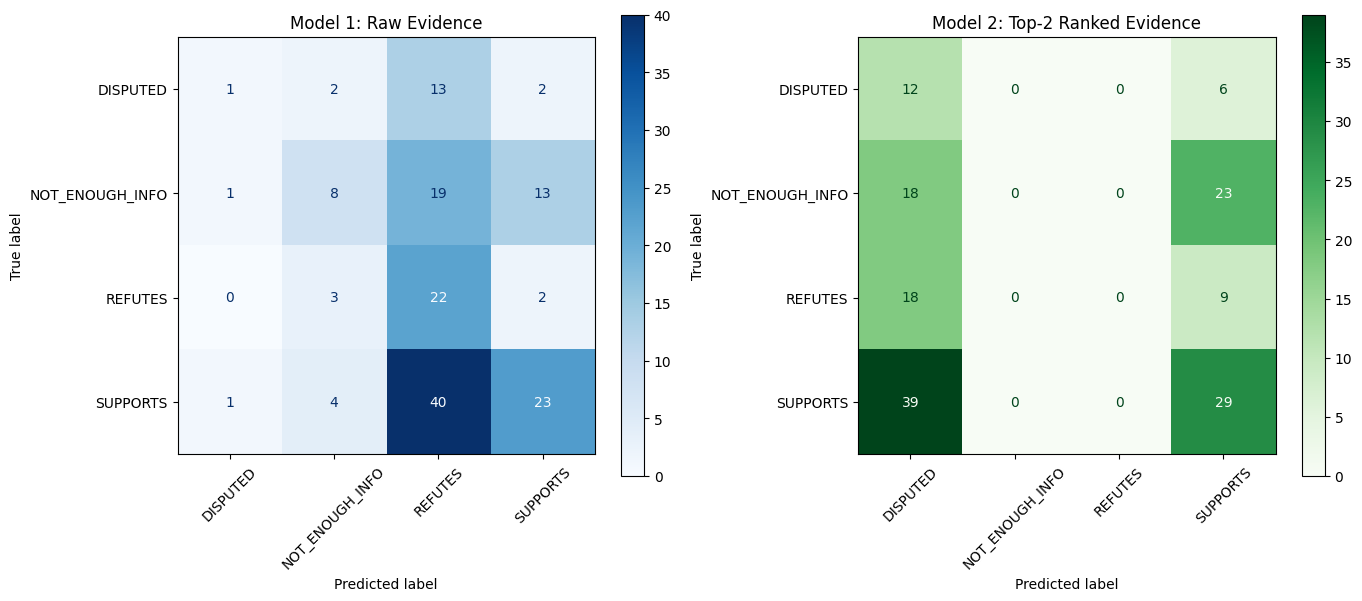

In [20]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Create reusable evaluation function to return labels
def get_predictions_and_labels(model, loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in loader:
            input_ids = batch["input_ids"].to(device)
            labels = batch["label"].to(device)
            outputs = model(input_ids)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return all_labels, all_preds

# Get labels and predictions
y_true_1, y_pred_1 = get_predictions_and_labels(model1, dev_loader)  # model1: raw evidence
y_true_2, y_pred_2 = get_predictions_and_labels(model2, dev_loader)  # model2: top-2 evidence

# Confusion matrix labels
class_names = label_encoder.classes_

# Plot side-by-side confusion matrices
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

cm1 = confusion_matrix(y_true_1, y_pred_1)
ConfusionMatrixDisplay(cm1, display_labels=class_names).plot(ax=axs[0], cmap='Blues', xticks_rotation=45)
axs[0].set_title("Model 1: Raw Evidence")

cm2 = confusion_matrix(y_true_2, y_pred_2)
ConfusionMatrixDisplay(cm2, display_labels=class_names).plot(ax=axs[1], cmap='Greens', xticks_rotation=45)
axs[1].set_title("Model 2: Top-2 Ranked Evidence")

plt.tight_layout()
plt.show()